# Run FinalTestV2 and Visualise Results
This notebook:

1. Runs FinalTestV2.py as a script
2. Loads metrics.csv
3. Plots loss, training accuracy, and validation accuracy vs epoch
4. Loads dead-neuron CSVs and displays a heatmap

In [4]:
import numpy as np
import time

from Cifar10Loader import Cifar10Loader
from neural_network import NeuralNetwork
from preprocessor import Preprocessor
from datacatcher import DataCatcher

from layers.activation_functions import ReLU, Sigmoid
from layers.optimisers import SGD, SGDWithMomentum, Adam
from layers.l2_regulariser import L2Regularizer

# --------------------------------------------------
# Global settings
# --------------------------------------------------
np.random.seed(42)

CIFAR_DIR = "../dataset/cifar10"
LOG_DIR = "../task1-src/logs"

# --------------------------------------------------
# Experiment definitions
# --------------------------------------------------
EXPERIMENTS = [
    {
        "name": "T1b_relu_sgd_bs256_epochs101",
        "activation": "relu",
        "batch_size": 256,
        "epochs": 101,
        "optimiser": "sgd",
        "learning_rate": 0.1,
        "momentum": None,
        "l2": None
    },
    {
        "name": "T1b_sigmoid_sgd_bs256_epochs101",
        "activation": "sigmoid",
        "batch_size": 256,
        "epochs": 101,
        "optimiser": "sgd",
        "learning_rate": 0.05,
        "momentum": None,
        "l2": None
    },
]

# --------------------------------------------------
# Helper functions
# --------------------------------------------------
def build_optimiser(cfg):
    if cfg["optimiser"] == "sgd":
        return SGD(learning_rate=cfg["learning_rate"])
    if cfg["optimiser"] == "momentum":
        return SGDWithMomentum(
            learning_rate=cfg["learning_rate"],
            momentum=cfg["momentum"]
        )
    if cfg["optimiser"] == "adam":
        return Adam(learning_rate=cfg["learning_rate"])
    raise ValueError("Unknown optimiser")

def build_layers(activation_name, l2):
    """
    IMPORTANT:
    Each layer gets its OWN activation instance.
    """
    if activation_name == "relu":
        act1 = ReLU()
        act2 = ReLU()
    elif activation_name == "sigmoid":
        act1 = Sigmoid()
        act2 = Sigmoid()
    else:
        raise ValueError("Unknown activation")

    return [
        {
            "n_inputs": 3072,
            "n_neurons": 1024,
            "activation": act1,
            "dropout": None,
            "l2": l2
        },
        {
            "n_inputs": 1024,
            "n_neurons": 256,
            "activation": act2,
            "dropout": None,
            "l2": l2
        },
        {
            "n_inputs": 256,
            "n_neurons": 10,
            "activation": None,
            "dropout": None,
            "l2": None
        }
    ]

# --------------------------------------------------
# Load data 
# --------------------------------------------------
print("Loading CIFAR-10...")
loader = Cifar10Loader(CIFAR_DIR)
X_train_raw, y_train_raw = loader.load_train_data()
X_test_raw, y_test_raw = loader.load_test_data()

preprocessor = Preprocessor()
X_train, y_train, X_val, y_val = preprocessor.preprocess_train_data(
    X_train_raw, y_train_raw, train_ratio=0.9
)
X_test, y_test = preprocessor.preprocess_test_data(
    X_test_raw, y_test_raw
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# --------------------------------------------------
# Run experiments
# --------------------------------------------------
for cfg in EXPERIMENTS:
    print("\n" + "=" * 60)
    print(f"Running experiment: {cfg['name']}")
    print("=" * 60)

    # Stabilise sigmoid runs
    if cfg["activation"] == "sigmoid":
        np.random.seed(42)

    l2 = L2Regularizer(cfg["l2"]) if cfg["l2"] else None

    layer_config = build_layers(cfg["activation"], l2)
    optimiser = build_optimiser(cfg)

    # ---- DataCatcher ----
    data_catcher = DataCatcher(
        base_dir=LOG_DIR,
        config={
            "experiment_name": cfg["name"],
            "metrics": True,
            "activation_logging": True,
            "activation_type": cfg["activation"],
            "layers": [0, 1]
        }
    )

    # ---- Network ----
    network = NeuralNetwork(
        layer_config=layer_config,
        optimiser=optimiser
    )

    start = time.time()

    network.train(
        X=X_train,
        Y_true=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs=cfg["epochs"],
        batch_size=cfg["batch_size"],
        data_catcher=data_catcher
    )

    duration = time.time() - start
    test_acc = network.accuracy(X_test, y_test)

    data_catcher.save_activation_logs()

    print(f"Finished {cfg['name']}")
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Time taken  : {duration:.2f}s")

print("\nAll experiments completed.")


Loading CIFAR-10...
Train: (45000, 3072) Val: (5000, 3072) Test: (10000, 3072)

Running experiment: T1b_relu_sgd_bs256_epochs101
Epoch 0, Loss: 2.2667, Training Accuracy: 0.16, Validation Accuracy: 0.16


KeyboardInterrupt: 

RUN: T1b_relu_sgd_bs256_epochs101


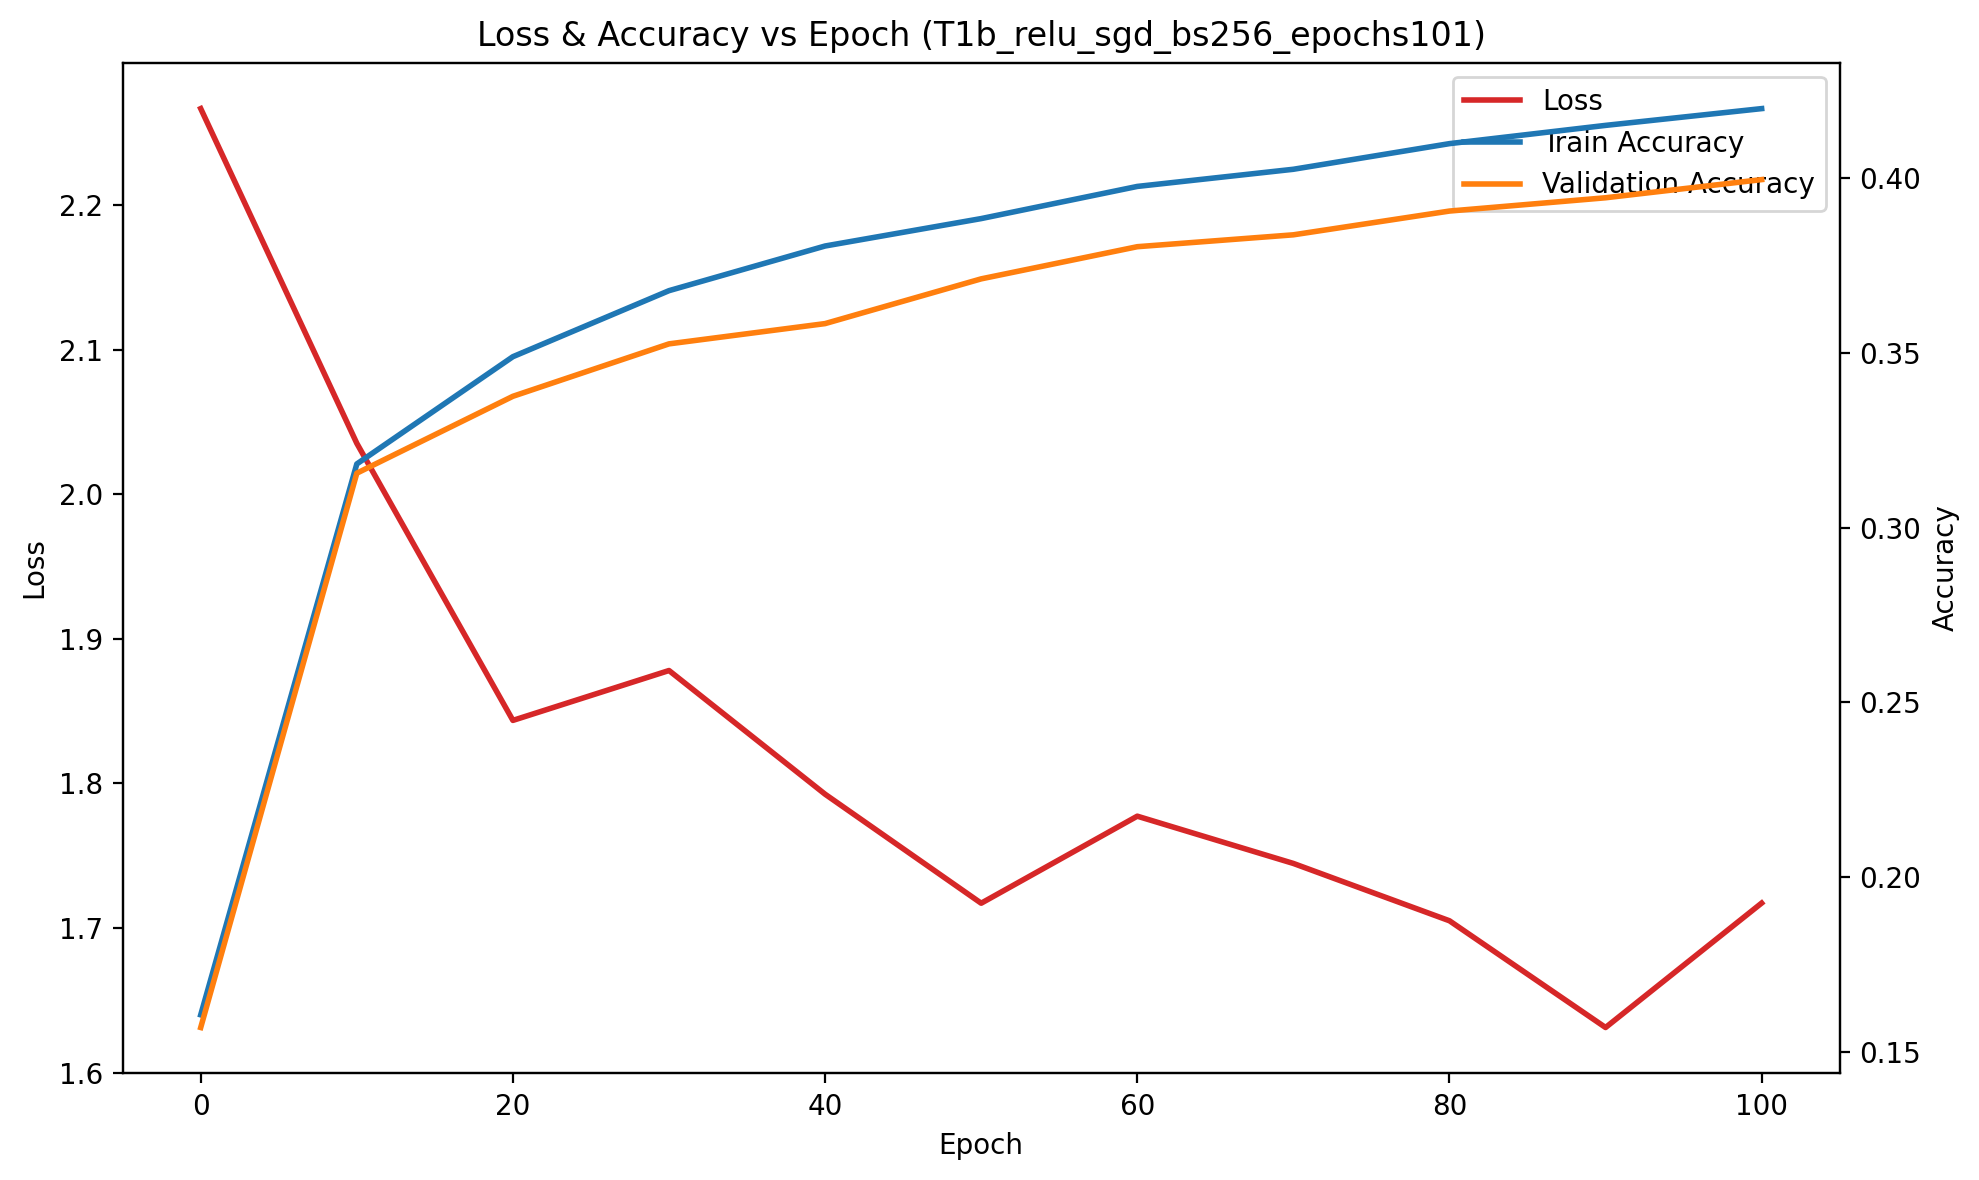

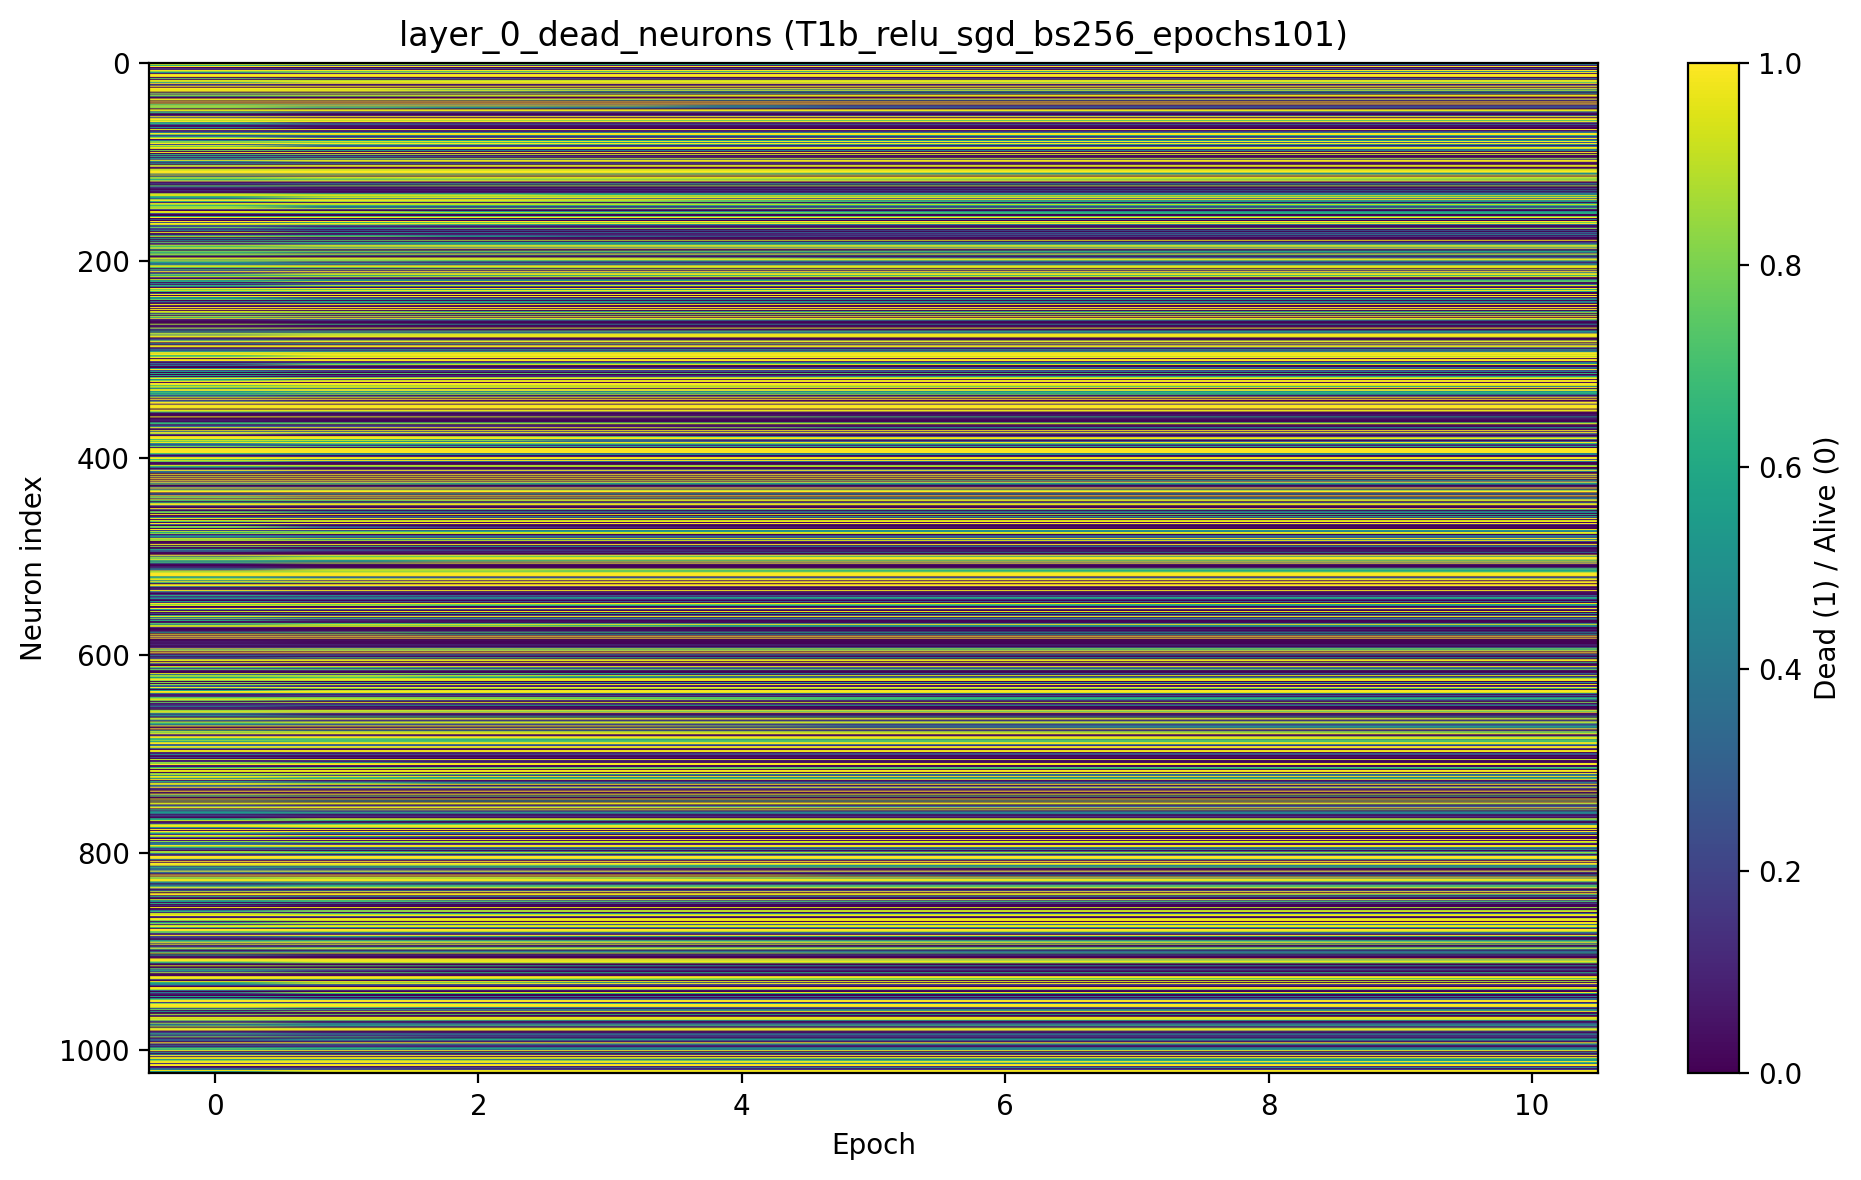

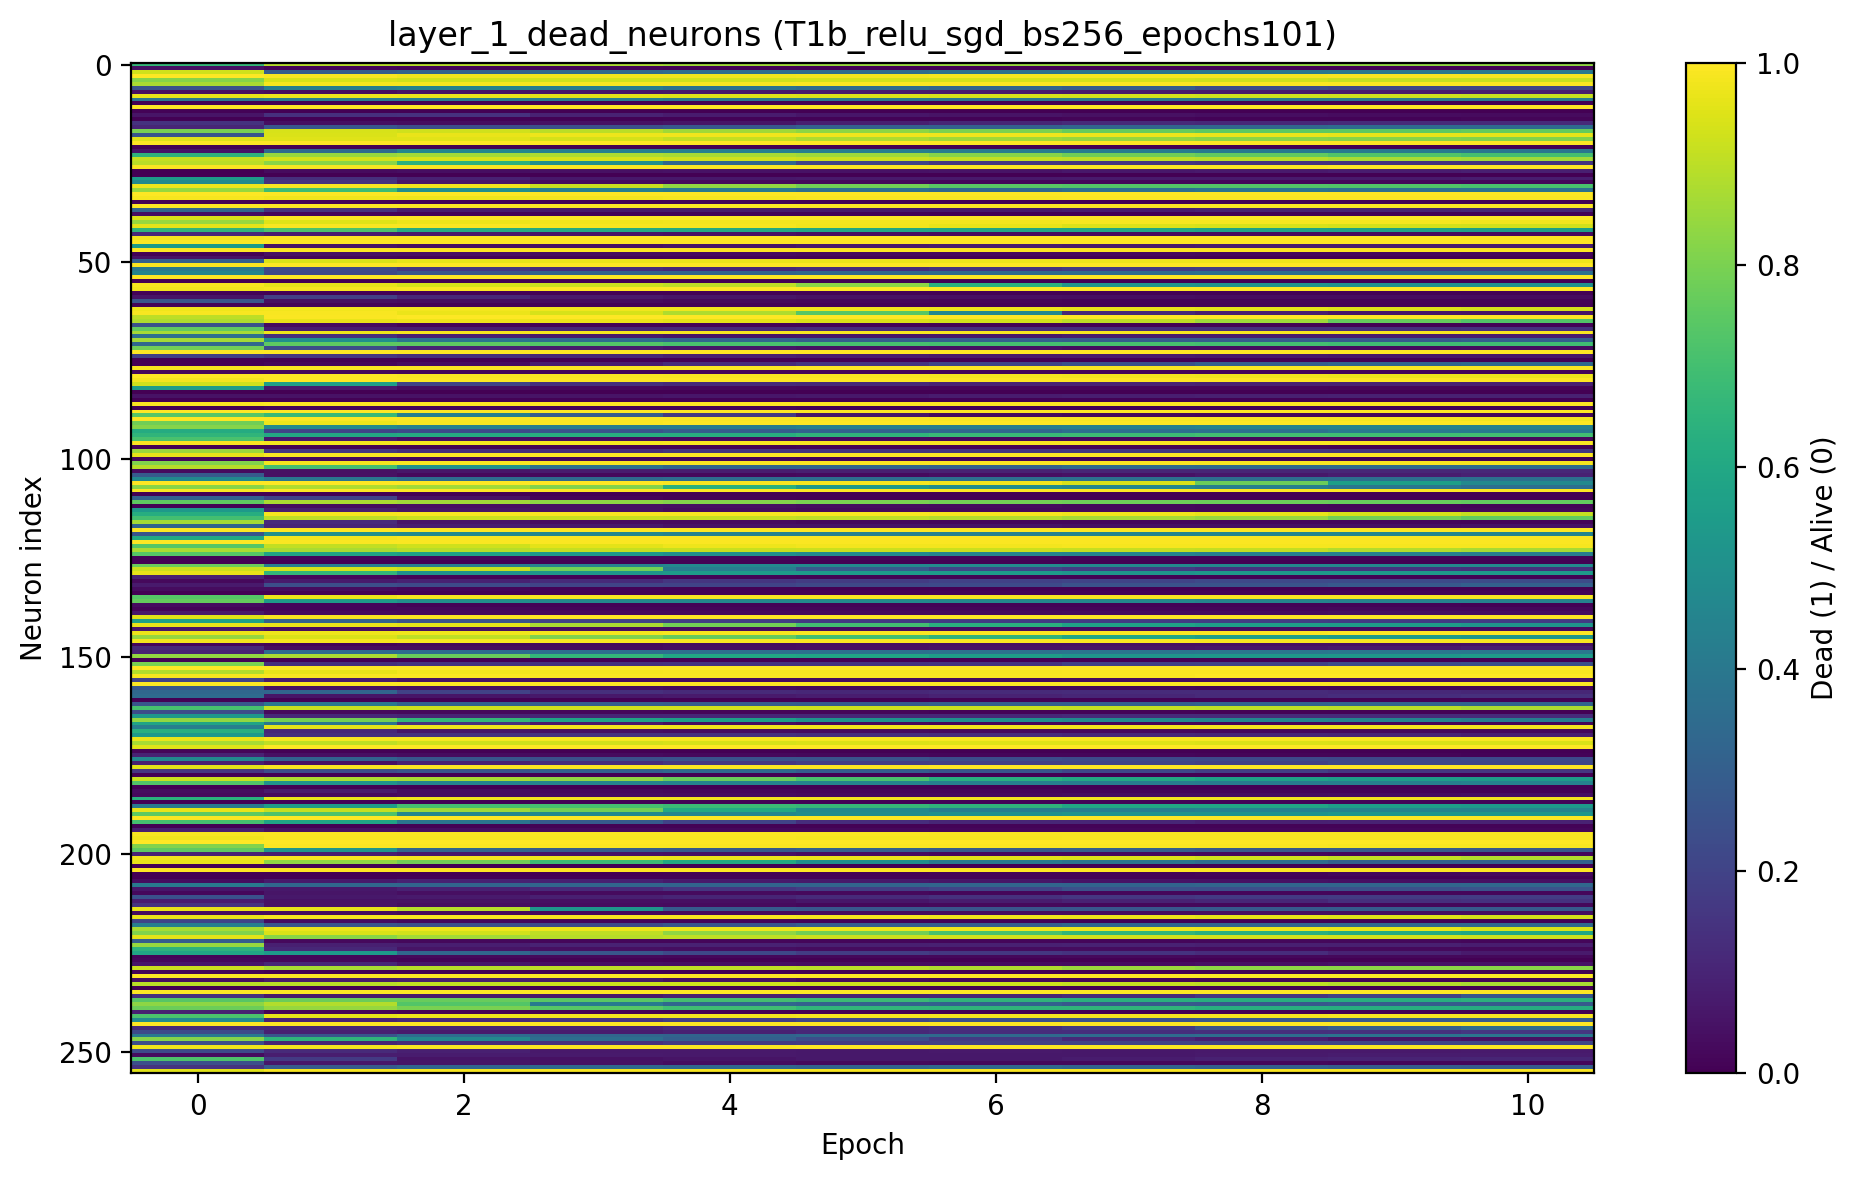

RUN: T1b_sigmoid_sgd_bs256_epochs101


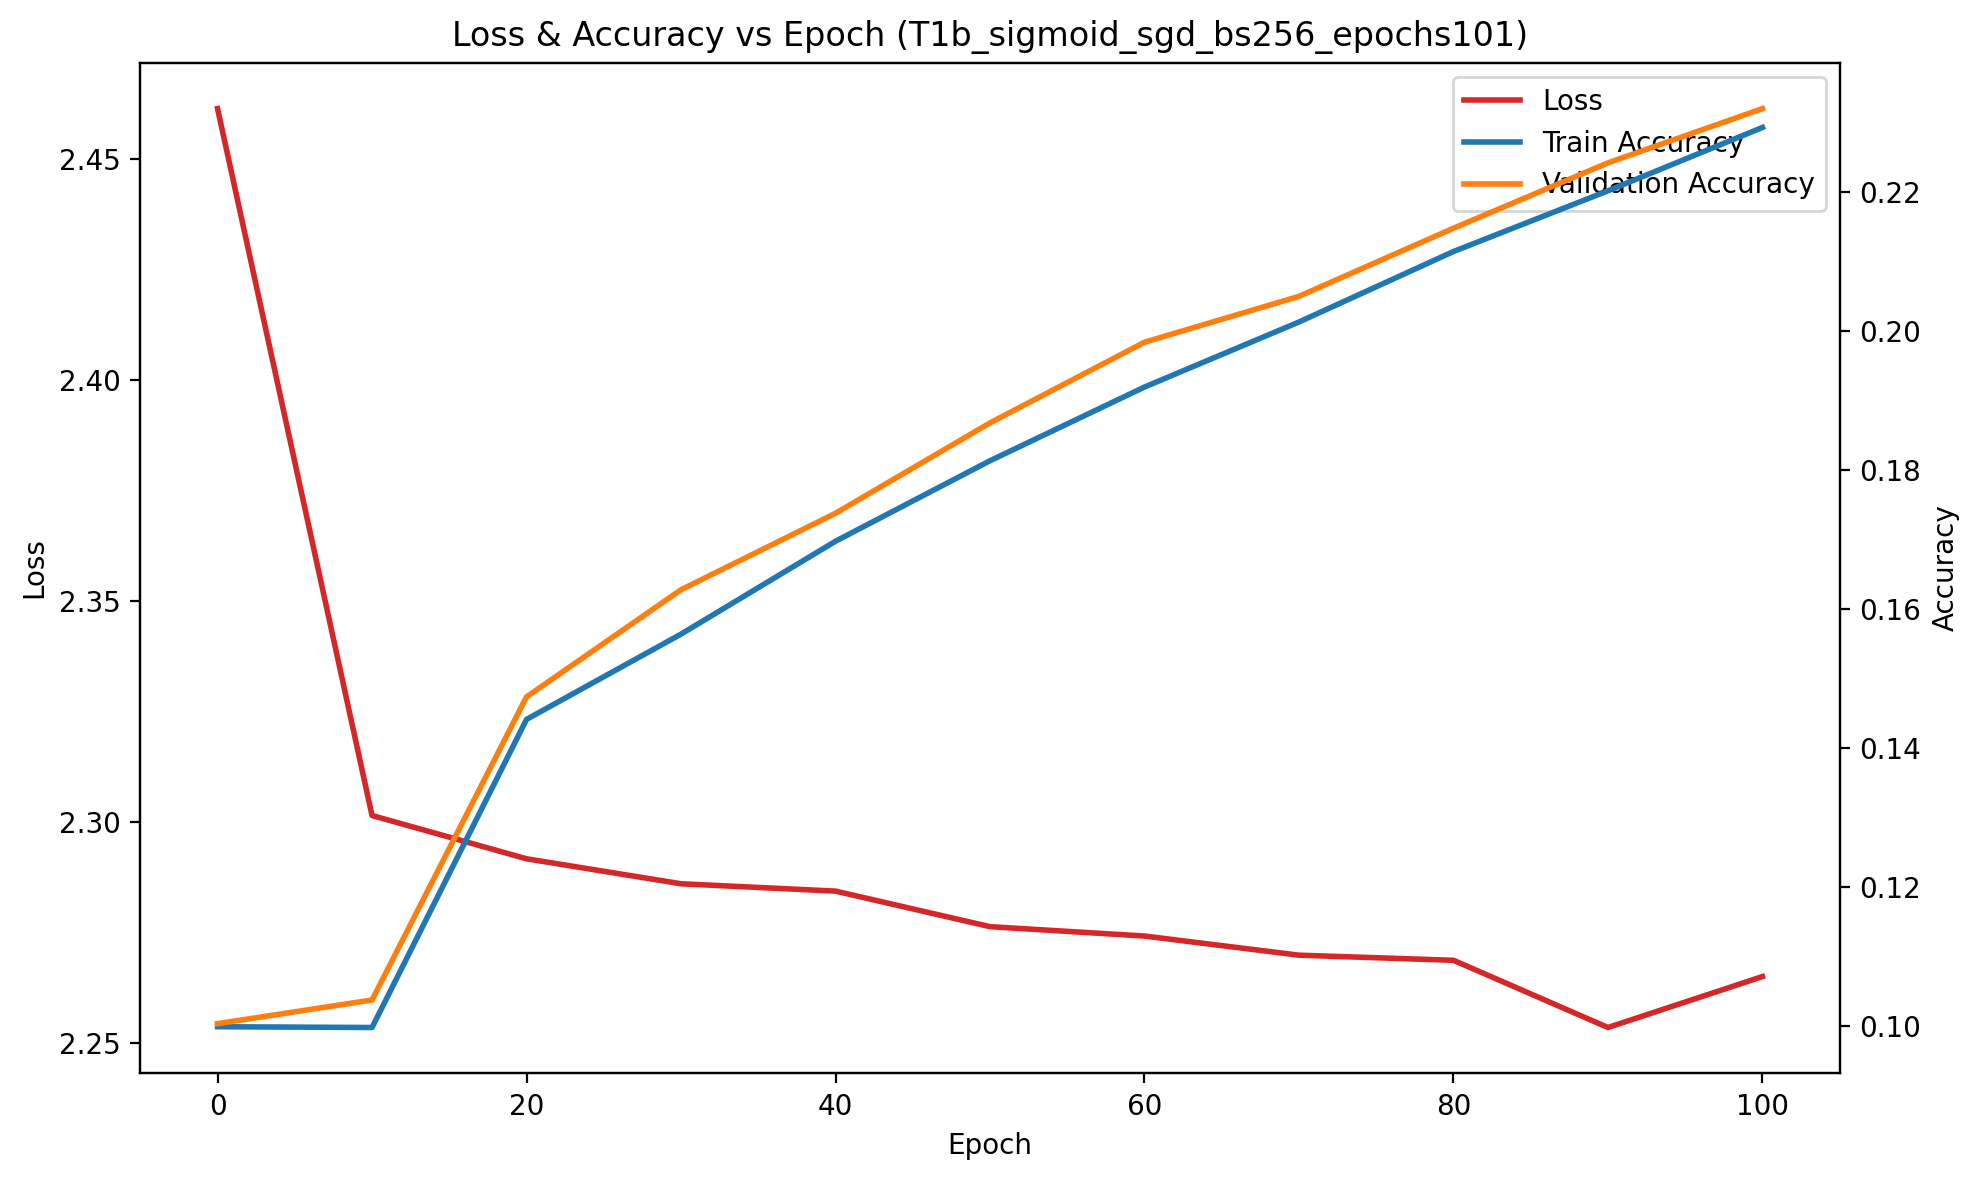

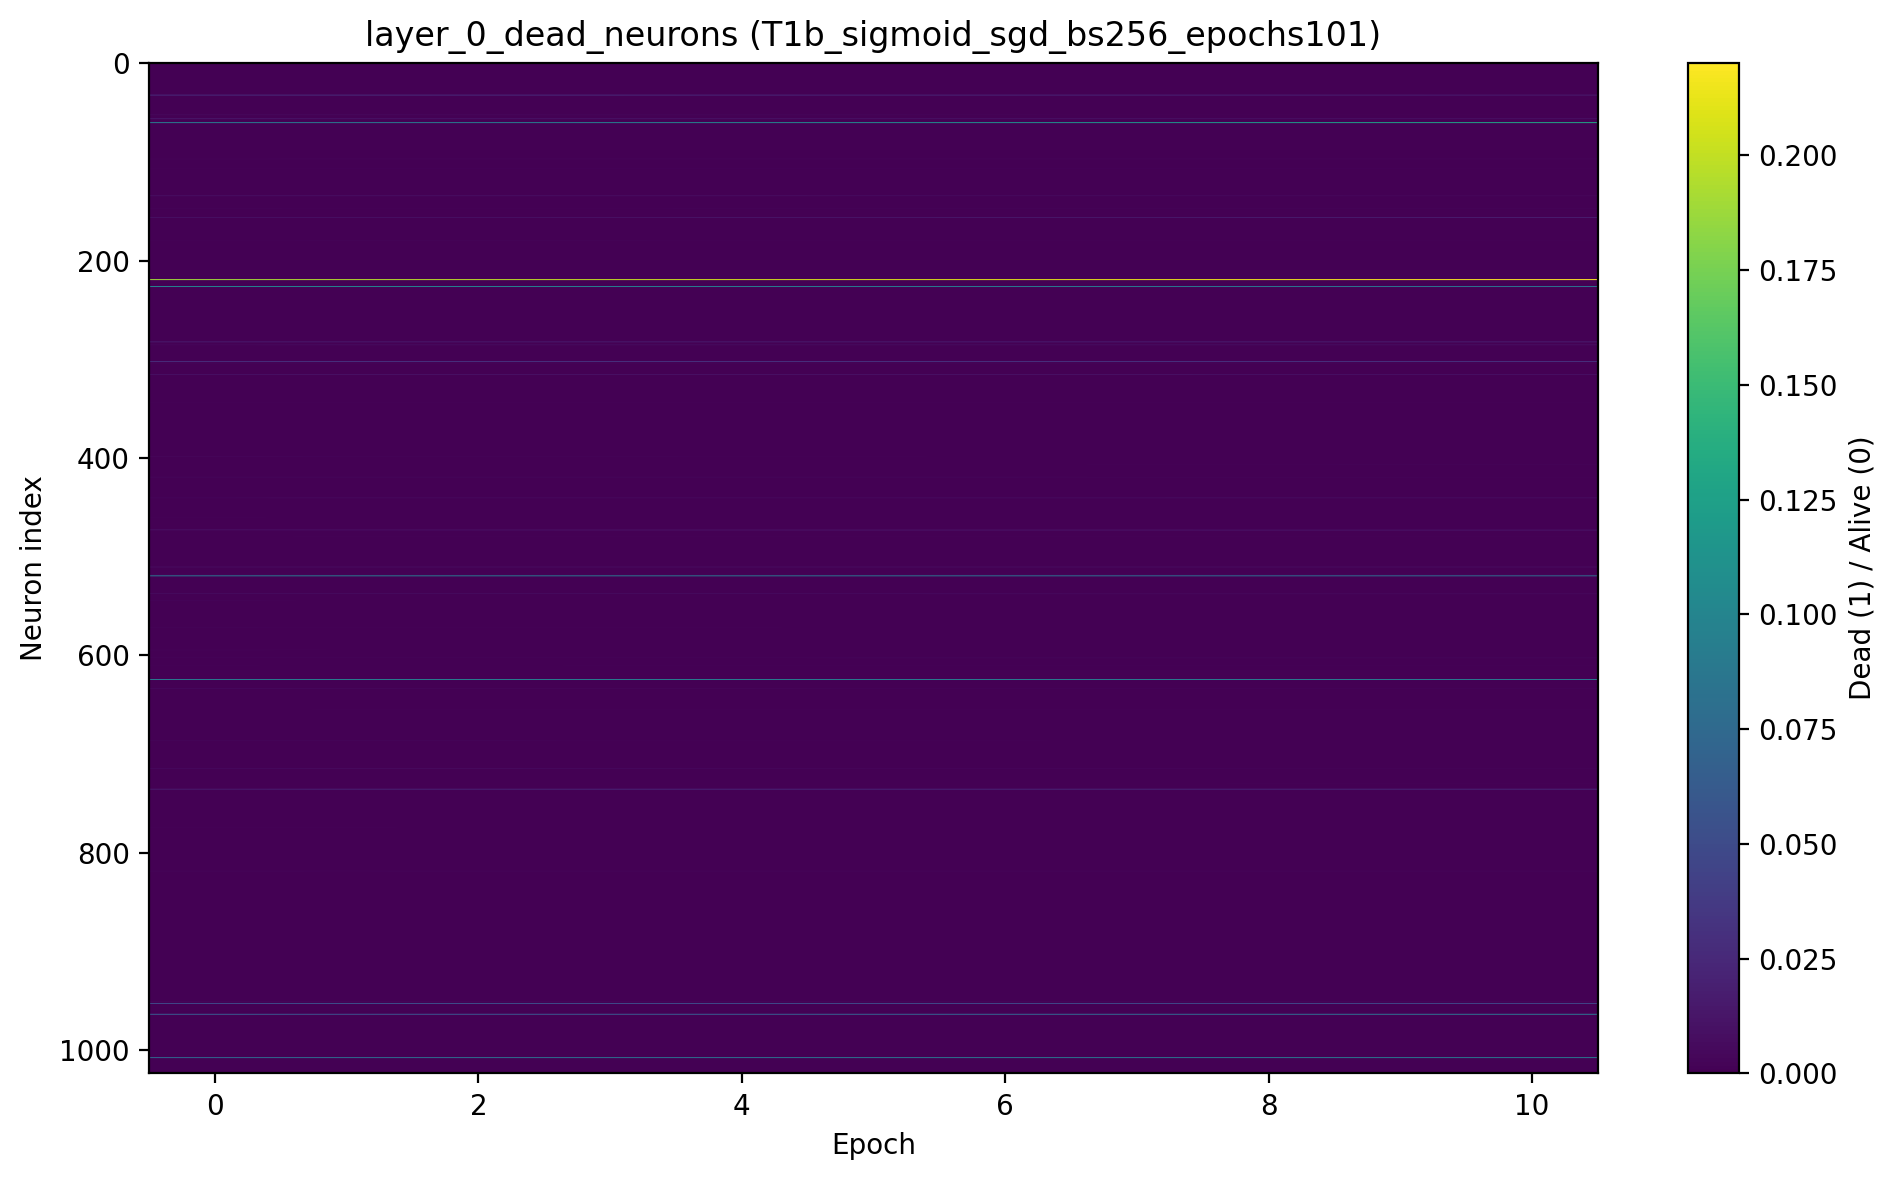

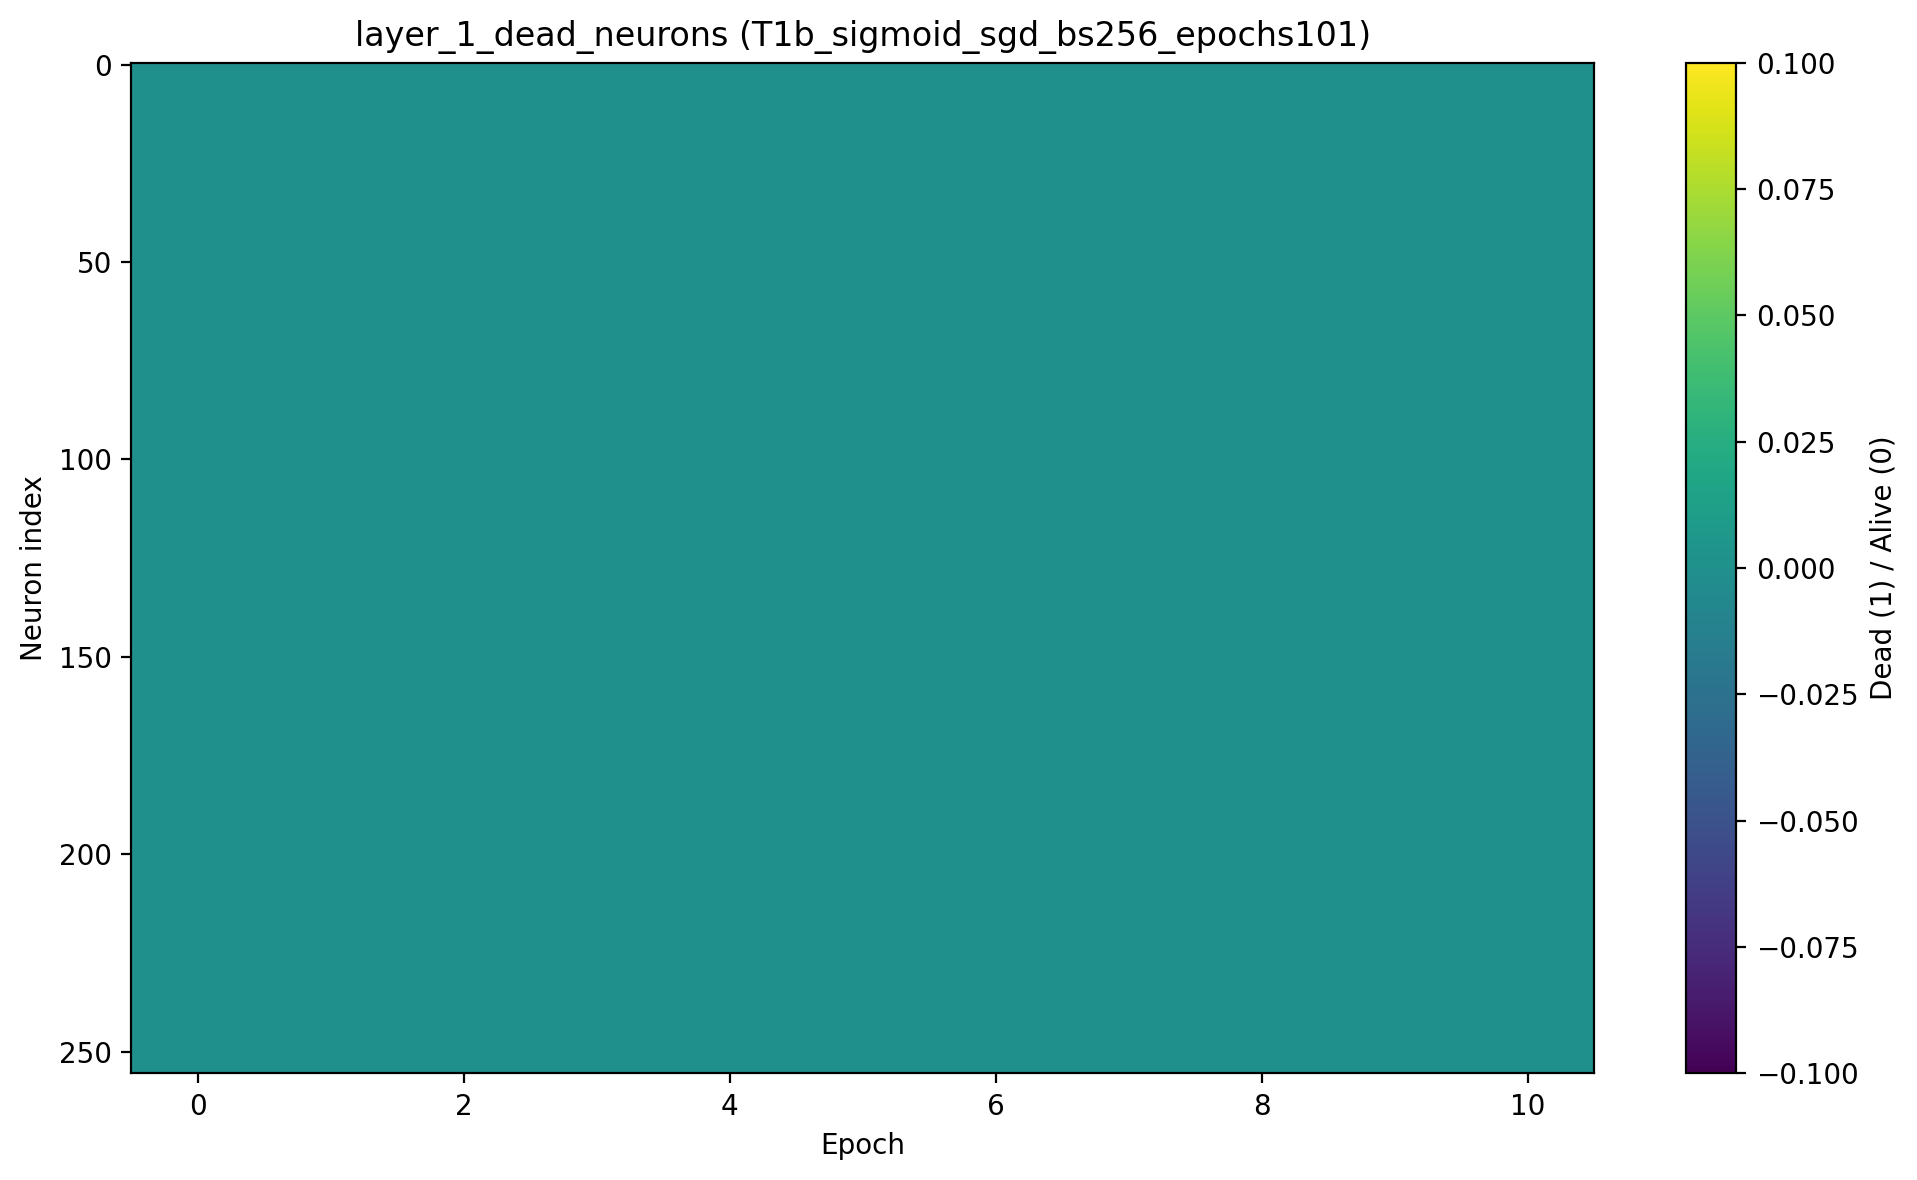

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

LOGS_DIR = "logs"

for run_name in sorted(os.listdir(LOGS_DIR)):
    run_path = os.path.join(LOGS_DIR, run_name)
    if not os.path.isdir(run_path):
        continue

    print("=" * 60)
    print(f"RUN: {run_name}")
    print("=" * 60)

    # ---- Metrics (combined plot with two Y axes) ----
    metrics_path = os.path.join(run_path, "metrics.csv")
    if os.path.exists(metrics_path):
        metrics = pd.read_csv(metrics_path)

        # 👇 High-resolution figure
        fig, ax1 = plt.subplots(figsize=(10, 6), dpi=200)

        # Loss on left Y-axis
        loss_line, = ax1.plot(
            metrics['epoch'],
            metrics['loss'],
            label='Loss',
            color='tab:red',
            linewidth=2
        )
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f"Loss & Accuracy vs Epoch ({run_name})")

        # Accuracy on right Y-axis
        ax2 = ax1.twinx()
        train_line, = ax2.plot(
            metrics['epoch'],
            metrics['train_accuracy'],
            label='Train Accuracy',
            linewidth=2
        )
        val_line, = ax2.plot(
            metrics['epoch'],
            metrics['validation_accuracy'],
            label='Validation Accuracy',
            linewidth=2
        )
        ax2.set_ylabel('Accuracy')

        # Combined legend
        lines = [loss_line, train_line, val_line]
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='best')

        plt.tight_layout()
        plt.show()
    else:
        print("No metrics.csv found")

    # ---- Dead neuron heatmaps ----
    for file in sorted(os.listdir(run_path)):
        if file.startswith("layer_") and file.endswith("_dead_neurons.csv"):
            layer_path = os.path.join(run_path, file)
            dead_df = pd.read_csv(layer_path)

            data = dead_df.drop(columns=['neuron']).values

            plt.figure(figsize=(10, 6), dpi=100)
            plt.imshow(data, aspect='auto')
            plt.colorbar(label='Dead (1) / Alive (0)')
            plt.xlabel('Epoch')
            plt.ylabel('Neuron index')
            plt.title(f"{file.replace('.csv','')} ({run_name})")
            plt.tight_layout()
            plt.show()
